In [1]:
import pandas as pd
import numpy as np 
import altair as alt
from altair import datum
import geopandas as gpd
import matplotlib as mpl

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.lines as mlines

import random



import baltic as bt
from augur import frequencies,frequency_estimators


import datetime
from datetime import datetime as dt
from datetime import timedelta


import math
import time
import sys
import unicodedata
# import unidecode ## for removing diacritics from example geoJSON

import numpy as np
from scipy.interpolate import UnivariateSpline ## used to smooth counts of lineages in each location at any given time
from scipy.interpolate import interp1d ## used to linearly interpolate between data points used in colouring polygons
from sklearn.decomposition import IncrementalPCA ## used to identify PCA1 when automatically producing a colour map

import requests ## used to fetch examples from internet
import json ## used for importing JSONs
try:
    from StringIO import StringIO as sio
    from cStringIO import StringIO as csio
except ImportError:
    from io import StringIO as sio
    from io import BytesIO as csio
    


from Bio import Phylo

alt.data_transformers.disable_max_rows()


DataTransformerRegistry.enable('default')

In [3]:
## some of the mpox seqs have repeated names unfortunetely, 
## so this takes in the nextstrain json and deduplicates names so that they can be read into baltic. 
def make_unique_name(name, existing_names):
    counter = 1
    new_name = name
    while new_name in existing_names:
        new_name = f"{name}_{counter}"
        counter += 1
    return new_name

def process_node(node, existing_names):
    if isinstance(node, dict):
        if "name" in node:
            original_name = node["name"]
            if original_name in existing_names:
                new_name = make_unique_name(original_name, existing_names)
                print(f"Renaming {original_name} to {new_name}")
                node["name"] = new_name
            existing_names.add(node["name"])
        for key, value in node.items():
            if isinstance(value, (dict, list)):
                process_node(value, existing_names)
    elif isinstance(node, list):
        for item in node:
            process_node(item, existing_names)

def check_and_rename_nodes(input_file, output_file):
    with open(input_file, 'r') as file:
        data = json.load(file)

    existing_names = set()
    process_node(data, existing_names)

    with open(output_file, 'w') as file:
        json.dump(data, file, indent=4)

    print(f"Processing complete. Output written to {output_file}")

# Example usage
input_file = '../mpox_build/phylogenetic/auspice/mpox_allcladeIIseqs.json'  # Replace with your actual input file path
output_file = 'deduplicated_tree.json'  # Replace with your desired output file path
check_and_rename_nodes(input_file, output_file)


Renaming MPXV/Germany/2022/RKI071 to MPXV/Germany/2022/RKI071_1
Renaming RNA to RNA_1
Renaming RNA to RNA_2
Renaming RNA to RNA_3
Renaming MPXV_USA_2022_MA0003 to MPXV_USA_2022_MA0003_1
Renaming RNA to RNA_4
Renaming RNA to RNA_5
Renaming RNA to RNA_6
Renaming RNA to RNA_7
Renaming RNA to RNA_8
Renaming MPXV/Germany/2022/RKI272 to MPXV/Germany/2022/RKI272_1
Renaming RNA to RNA_9
Renaming LBMB-UTP_MP-011_VAC to LBMB-UTP_MP-011_VAC_1
Renaming MPXV/Germany/2022/RKI056 to MPXV/Germany/2022/RKI056_1
Renaming RNA to RNA_10
Renaming MPXV/Germany/2022/RKI070 to MPXV/Germany/2022/RKI070_1
Renaming MPXV/Germany/2022/RKI072 to MPXV/Germany/2022/RKI072_1
Processing complete. Output written to deduplicated_tree.json


In [5]:
tree_file = "deduplicated_tree.json"
nx_tree = json.load(open(tree_file))
tree=nx_tree['tree']
meta=nx_tree['meta']



json_translation={'absoluteTime':lambda k: k.traits['node_attrs']['num_date']['value'],'name':'name'} ## allows baltic to find correct attributes in JSON, height and name are required at a minimum
json_meta={'file':meta,'traitName':'region'} ## if you want auspice sty

bt_tree, meta=bt.loadJSON(tree_file)


Tree height: 7.447902
Tree length: 1241.475912
annotations present

Numbers of objects in tree: 9525 (1853 nodes and 7672 leaves)



In [6]:
def convertDate(x,start,end):
    """ Converts calendar dates between given formats """
    return dt.strftime(dt.strptime(x,start),end)

In [7]:
bt_tree.cmap

{'clade_membership': {'IIb': '#DEA73C'},
 'lineage': {'A': '#5E1D9D',
  'B.1': '#403CC5',
  'B.1.1': '#3F4CCB',
  'B.1.2': '#3E5DD0',
  'B.1.3': '#416CCE',
  'C.1': '#447BCD',
  'C.1.1': '#4887C6',
  'B.1.4': '#4D93BE',
  'B.1.5': '#539CB3',
  'B.1.6': '#5AA5A8',
  'B.1.7': '#62AB9C',
  'B.1.8': '#6AB18F',
  'B.1.9': '#74B582',
  'B.1.10': '#7EB876',
  'B.1.11': '#89BB6B',
  'B.1.12': '#94BD61',
  'B.1.13': '#A0BE59',
  'B.1.14': '#ABBD51',
  'B.1.15': '#B7BD4B',
  'B.1.16': '#C2BA46',
  'B.1.17': '#CCB742',
  'B.1.18': '#D5B13F',
  'B.1.19': '#DDAA3C',
  'B.1.20': '#E19F3A',
  'B.1.21': '#E69537',
  'B.1.22': '#E68534',
  'A.2': '#E67631',
  'A.2.1': '#E4632E',
  'A.2.2': '#E14F2A',
  'A.2.3': '#DE3C26',
  'A.3': '#DB2823'},
 'region': {'Asia': '#447CCD',
  'Oceania': '#5EA9A1',
  'Africa': '#8ABB6A',
  'Europe': '#BEBB48',
  'South America': '#E29E39',
  'North America': '#E2562B'},
 'country': {'Israel': '#5E1D9D',
  'Thailand': '#4E20AB',
  'China': '#482BB6',
  'Vietnam': '#4137C2

In [8]:
##this can be used to find root locations and make predefined clusters into individual subtrees.
def enumerate_subtrees_clusters_region(tree):
    
    traitName="focus_areas"
    region_of_interest = ["Los Angeles County"]

    tree.root.traits[traitName]='ancestor' ## give root node some trait value that's different from what the actual tree root has, so it registers as a switch

    #tree_strings={division:[] for division in division_order}
    subtype_trees=[]

    for k in sorted(tree.Objects,key=lambda x:x.height):
        kp=k.parent     # kp is the parent node of k
        
        ## get current node's (k) and its parent's (kp) trait states
        kloc=k.traits[traitName]      # kloc = trait of k; kc = trait of k; they are the same thing
        if traitName in k.parent.traits:       # if parent has a trait block, use that trait, else assign to ancestor
            kploc=kp.traits[traitName]              # kploc = trait of parental node
        else:
            kploc='ancestor'
        
        kc=kloc     
        ## if states do not match
        if (kloc != kploc)  & (kloc in region_of_interest):      # if node and parental node do not have the same trait
            #N_children=len(k.leaves)
            traverse_condition=lambda w:w.traits[traitName] ==kloc # in division_order     # traverse tree for all nodes whose traitname = kc
            #print('subtree resulting from %s>%s switch, traversing within %s'%(kploc,kloc,kloc))
            subtree=tree.subtree(k,traverse_condition=traverse_condition) #traitName = traitName ## this function returns a new baltic object that contains a trait-traversed subtree, starting from node k, for as long as the traversal stays within the starting trait value state

            if subtree != None:
                subtree.traverse_tree()
                subtree.sortBranches()

                #tree_strings[kloc].append(subtree.toString()) ## remember subtree string, subtree object itself
                subtype_trees.append((kploc, kloc, subtree))
    
    return(subtype_trees)

In [9]:
subtype_trees = enumerate_subtrees_clusters_region(bt_tree)


In [10]:
colors = {"B.1.20":"#D0A854",
          "B.1.21":"#2664A5",
          "B.1.22":"#A76BB1",
          "C.1":"#D07954",
          "C.1.1":"#356D4C"
         }

In [11]:
bt_tree.cmap["lineage"]

{'A': '#5E1D9D',
 'B.1': '#403CC5',
 'B.1.1': '#3F4CCB',
 'B.1.2': '#3E5DD0',
 'B.1.3': '#416CCE',
 'C.1': '#447BCD',
 'C.1.1': '#4887C6',
 'B.1.4': '#4D93BE',
 'B.1.5': '#539CB3',
 'B.1.6': '#5AA5A8',
 'B.1.7': '#62AB9C',
 'B.1.8': '#6AB18F',
 'B.1.9': '#74B582',
 'B.1.10': '#7EB876',
 'B.1.11': '#89BB6B',
 'B.1.12': '#94BD61',
 'B.1.13': '#A0BE59',
 'B.1.14': '#ABBD51',
 'B.1.15': '#B7BD4B',
 'B.1.16': '#C2BA46',
 'B.1.17': '#CCB742',
 'B.1.18': '#D5B13F',
 'B.1.19': '#DDAA3C',
 'B.1.20': '#E19F3A',
 'B.1.21': '#E69537',
 'B.1.22': '#E68534',
 'A.2': '#E67631',
 'A.2.1': '#E4632E',
 'A.2.2': '#E14F2A',
 'A.2.3': '#DE3C26',
 'A.3': '#DB2823'}

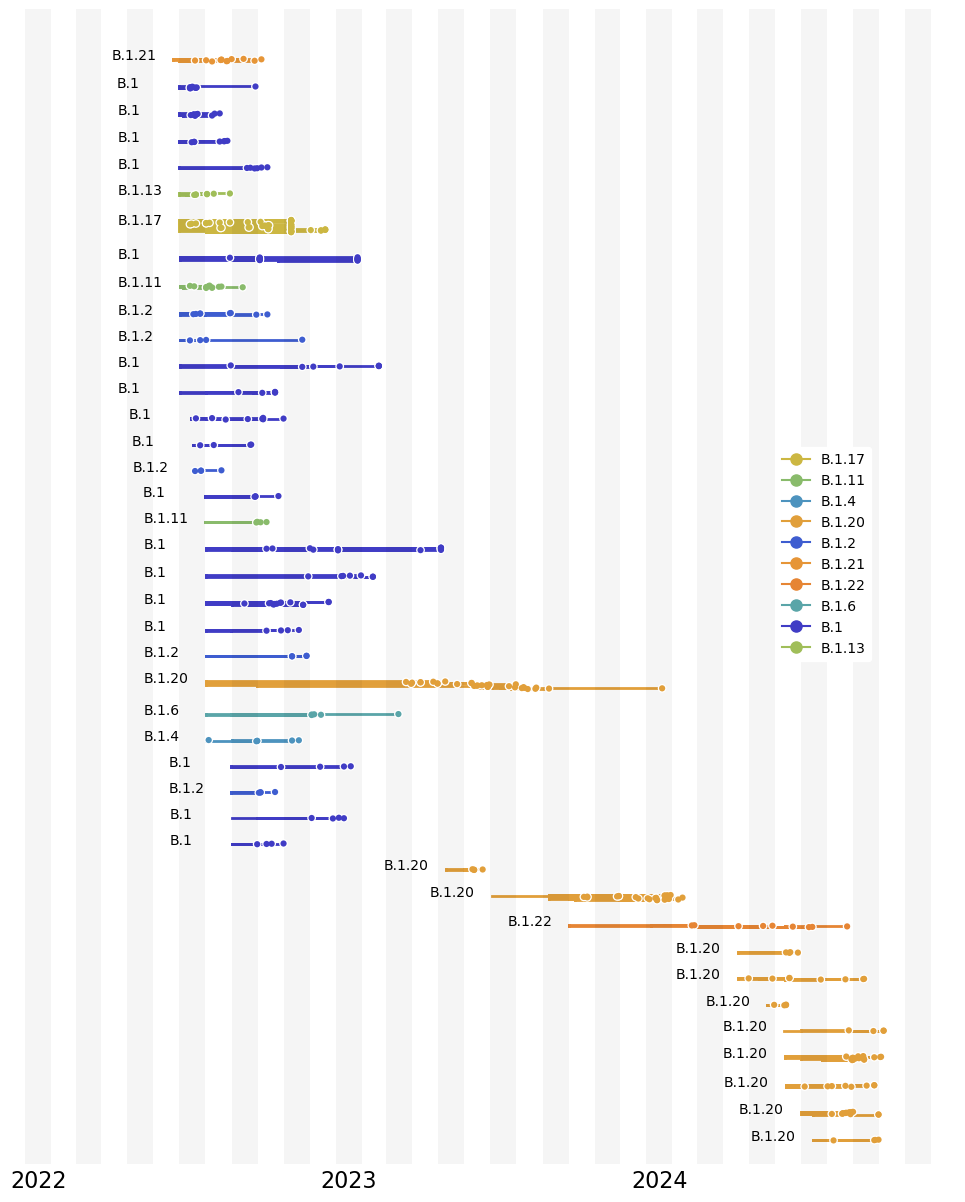

In [63]:
fig,ax = plt.subplots(figsize=(12,15),facecolor='w')
cumulativeY=0
branchWidth=2
region_of_interest = ["Los Angeles County"]
lineages_of_interest = ["B.1.20","B.1.21", "B.1.22", "C.1.1"]
lineage_list = []

for t,tr in enumerate(sorted(subtype_trees,key=lambda x:(-x[2].root.absoluteTime))): ## iterate over extracted subtrees sorted according to their root height and their size
    origin,root,loc_tree=tr
    #loc_tree.plotTree(ax)
    #print(tr)
    dates = []
    dates=[k.absoluteTime for k in loc_tree.Objects if k.branchType=='leaf'] ## get tip dates
    if len([k for k in loc_tree.Objects if k.branchType=='leaf']) >3:
        for k in loc_tree.Objects:
        #        if k.traits['node_attrs']['lineage']['value'] in lineages_of_interest: 
            #print(k)
            c='k'
            #print(k.traits)
            c=bt_tree.cmap["lineage"][k.traits['node_attrs']['lineage']['value']]

    #             if k.traits['focus_areas']=='Cook County':
    #                 z=1
    #             elif k.traits['focus_areas']=='King County':
    #                 z=2
    #             elif k.traits['focus_areas']=='Los Angeles County':
    #                 z=3
    #             elif k.traits['focus_areas']=='New York County':
    #                 z=4
            z=1
            x=k.absoluteTime
            y=k.y+cumulativeY

            xp=k.parent.absoluteTime
            if xp==0:
                xp=x

            if (k.branchType=='leaf'):
                ax.scatter(x,y,s=20,facecolor=bt_tree.cmap["lineage"][k.traits['node_attrs']['lineage']['value']],edgecolor='none',zorder=4)
                ax.scatter(x,y,s=40,facecolor='w',edgecolor='none',zorder=3)
                #ax.annotate(k.traits["lineage"], (x,y))
            else:
                yl=k.children[0].y+cumulativeY
                yr=k.children[-1].y+cumulativeY
                ax.plot([x,x],[yl,yr],color=c,lw=branchWidth,zorder=z)

            if loc_tree.Objects.index(k)!=0:
                ax.plot([x,xp],[y,y],color=c,lw=branchWidth,zorder=z)

            
        oriX=loc_tree.root.absoluteTime -0.2
        oriY=loc_tree.root.y +cumulativeY
        #ax.scatter(oriX,oriY,s=15,facecolor="k",edgecolor='k',lw=1,zorder=200) ## add big circle at base of tree to indicate origin
        ax.annotate(k.traits["lineage"], (oriX,oriY))

        cumulativeY+=loc_tree.ySpan+105

        lineage_list.append(k.traits['node_attrs']['lineage']['value'])
        #cumulative_y+=loc_tree.ySpan+8 

# add in a legend
    han_list = []

    # bbox to anchor puts a bounding box around where you want the legend to go, prop part is for text size
for key in region_of_interest:
    marker = mlines.Line2D(range(1), range(1), color = bt_tree.cmap["focus_areas"][key], marker='o', markerfacecolor = bt_tree.cmap["focus_areas"][key], label = key.title(), markersize = 8)
    han_list.append(marker)
    
# add in a legend
    han_list_2 = []

    # bbox to anchor puts a bounding box around where you want the legend to go, prop part is for text size
for key in set(lineage_list):
    marker = mlines.Line2D(range(1), range(1), color = bt_tree.cmap["lineage"][key], marker='o', markerfacecolor = bt_tree.cmap["lineage"][key], label = key.title(), markersize = 8)
    han_list_2.append(marker)
    


every=12
xDates=['%04d-%02d-01'%(y,m) for y in range(2017,2025) for m in range(1,13)]

[ax.axvspan(bt.decimalDate(xDates[x]),bt.decimalDate(xDates[x])+1/float(12),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xDates),2)]
ax.set_xticks([bt.decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%every==0])

ax.set_xticklabels([convertDate(x,'%Y-%m-%d','%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%every==0])
ax.tick_params(axis='x',labelsize=16,size=0)

#[ax.axvline(i,ls='--',lw=1,color='grey',zorder=0) for i in range(2019,2023)]

        
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(size=0)
#ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_xlim(bt.decimalDate('2022-01-01'),bt.decimalDate('2024-12-30'))
ax.set_ylim(-100,cumulativeY +105)

#ax.legend(handles = han_list, markerfirst = True, edgecolor="white", framealpha=1, bbox_to_anchor=[0.05, 0.20], loc=3,prop={'size': 16}, facecolor='w')
ax.legend(handles = han_list_2, markerfirst = True, edgecolor="white", framealpha=1, bbox_to_anchor=[0.8, 0.43], loc=3,prop={'size': 10}, facecolor='w')
[ax.spines[loc].set_visible(False) for loc in ['top','right', 'left']]


#ax2 = fig.add_axes([0.22, 0.2, 0.02, 0.2])
#mpl.colorbar.ColorbarBase(ax2, cmap=host_cmap,ticks=np.linspace(0.0,1.0,3))
#ax2.tick_params(size=5,labelsize=13)
#ax2.set_ylabel('posterior probability', size=15)
#ax3=ax2.twinx()
#ax3.set_ylim(0,1)
#ax3.set_yticks([0.0,1.0])
#ax3.set_yticklabels(['North King County','South King County'])
#ax3.tick_params(size=0,labelsize=12)
#plt.savefig('../figures/lineages_in_counties.png',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
## now look into migrations 

In [31]:
def enumerate_migration_events(tree):
        
    output_dict = {}
    migration_events_counter = 0
    region_of_interest = [ "Los Angeles County"]

    for k in tree.Objects:
#         if k.traits == {}:
#             k.traits = {'obs': 0.0, 'ns_kc':"root"}
#         elif k.traits['obs'] ==  0.0:
#             k.traits = {'obs': 0.0, 'ns_kc':"none"}
        
        trait = k.traits['focus_areas']
        parent_node = k.parent
        if ('root' in parent_node.traits) or (parent_node.traits == {}) :
            parent_trait = "root"
        
        # only write out migration events that are not from root to deme
#         elif trait in region_of_interest:
        else:

        
            parent_trait = parent_node.traits['focus_areas']
            
            if (trait != parent_trait):
                #if (parent_trait != "South_King_County") and (parent_trait != "North_King_County"):
                migration_events_counter += 1
                migration_event = parent_trait + "-to-" + trait
                migration_date = parent_node.absoluteTime + (k.absoluteTime - parent_node.absoluteTime) *random.uniform(0,1)
                children = parent_node.children
            if (trait != parent_trait)  & (parent_trait in region_of_interest):      # if node and parental node do not have the same trait. you can toggle this between child or parent trait in the second conditional to get imports or exports
                #N_children=len(k.leaves)
                traverse_condition=lambda w:w.traits['focus_areas'] ==trait # in division_order     # traverse tree for all nodes whose traitname = kc
                #print('subtree resulting from %s>%s switch, traversing within %s'%(kploc,kloc,kloc))
                subtree=tree.subtree(k,traverse_condition=traverse_condition) #traitName = traitName ## this function returns a new baltic object that contains a trait-traversed subtree, starting from node k, for as long as the traversal stays within the starting trait value state

                if subtree != None:
                    subtree.traverse_tree()
                    subtree.sortBranches()
  

                N_children=subtree.getExternal()

                #print(N_children)
                # write to output dictionary
                output_dict[migration_events_counter] = {"type":migration_event, "date":migration_date, 
                                                        "parent_host":parent_trait,
                                                        "child_host": trait, "children": len(N_children)}
    
    return(output_dict)

In [15]:
#need to convert the decimal dates back to calendar dates 
def convert_partial_year(number):

    year = int(number)
    d = timedelta(days=(number - year)*(365 + is_leap(year)))
    day_one = dt(year,1,1)
    date = d + day_one
    date = dt.strftime(date, '%Y-%m-%d')
    return date

In [16]:
def is_leap(number):
    if number == 2020:
        leap = 1
    else:
        leap = 0
    return leap

In [17]:
def convert_format(number):
    date = dt.strptime(number, '%Y-%m-%d')
    date = dt.strftime(date, '%Y-%m')
    return date

In [18]:
def source_of_intro(tree):

    ll, meta=bt.loadJSON(tree_file)
    
    
    #pull out migration events labeling parent and child nodes

    migrations_dict = enumerate_migration_events(ll)
    migrations_df = pd.DataFrame.from_dict(migrations_dict).T
    migrations_df.reset_index(inplace=True)



    #convert decimal year into year-month
    migrations_df['calendar_date'] = migrations_df.date.map(convert_partial_year)
    migrations_df['year-month'] = migrations_df['calendar_date'].map(convert_format)



    return(migrations_df)

In [32]:
overall_df = source_of_intro(tree_file)
overall_df


Tree height: 7.447902
Tree length: 1241.475912
annotations present

Numbers of objects in tree: 9525 (1853 nodes and 7672 leaves)



,index,type,date,parent_host,child_host,children,calendar_date,year-month
0,568,Los Angeles County-to-Global,2022.646883,Los Angeles County,Global,1,2022-08-25,2022-08
1,569,Los Angeles County-to-New York City,2022.561604,Los Angeles County,New York City,1,2022-07-24,2022-07
2,606,Los Angeles County-to-Other California,2023.074102,Los Angeles County,Other California,1,2023-01-28,2023-01
3,702,Los Angeles County-to-North America,2022.527006,Los Angeles County,North America,1,2022-07-12,2022-07
4,703,Los Angeles County-to-Other California,2022.538825,Los Angeles County,Other California,1,2022-07-16,2022-07
...,...,...,...,...,...,...,...,...
81,1912,Los Angeles County-to-Other California,2024.418542,Los Angeles County,Other California,8,2024-06-01,2024-06
82,1926,Los Angeles County-to-Other California,2024.328317,Los Angeles County,Other California,1,2024-04-29,2024-04
83,1927,Los Angeles County-to-Other California,2024.472454,Los Angeles County,Other California,1,2024-06-21,2024-06
84,1937,Los Angeles County-to-Other California,2024.336013,Los Angeles County,Other California,1,2024-05-02,2024-05


In [20]:
overall_df.type.value_counts()

Global-to-Los Angeles County              93
North America-to-Los Angeles County       79
New York City-to-Los Angeles County       65
Other California-to-Los Angeles County    52
Cook County-to-Los Angeles County         23
Washington-to-Los Angeles County          13
Name: type, dtype: int64

In [33]:
overall_df= overall_df[["type", "date", "parent_host", "child_host", "calendar_date", "year-month"]]

In [22]:
clust_over_time =  alt.Chart(overall_df).mark_bar(opacity = 1, interpolate='monotone', size = 10).encode(
    alt.X('year-month:T', axis = alt.Axis(grid= False, format = "%B %Y", title = "")),
    alt.Y('count():Q', axis=alt.Axis(title="Number of Local Outbreak Clusters", grid=False, labelFontSize = 14), stack = None), 
).transform_filter(datum.child_host == "Los Angeles County"
).properties(
    width=300,
    height=200
)
clust_over_time

alt.Chart(...)

In [23]:
clust_size_over_time =  alt.Chart(overall_df).mark_bar(opacity = 1, interpolate='monotone',size = 10).encode(
    alt.X('year-month:T', axis = alt.Axis(grid= False, format = "%B %Y", title = "")),
    alt.Y('children:Q', axis=alt.Axis(title="Mean Size of Local Outbreak Clusters", grid=False, labelFontSize = 14,), stack = None), 
).transform_filter(datum.child_host == "Los Angeles County"  
).properties(
    width=300,
    height=200
)#.transform_filter(datum.size_of_cluster <10)


clust_size_over_time

alt.Chart(...)

In [24]:
domain = ['Cook County', 'Global', 'King County' ,"New York City", "North America", "Other California"]
range_ = ['#EEC060', '#2664A5', '#A76BB1', "#EEA160", "#356D4C", "#72b7b2"]

In [29]:
chart = alt.Chart(overall_df).transform_aggregate(
        count='count()',
        groupby=["child_host",'year-month', "parent_host"]
        ).mark_bar( interpolate = "monotone", size = 13).encode(
            alt.X("year-month:T", title="",  axis=alt.Axis(title=None, grid=False, tickCount = "month",format="%b %Y")),  # Assuming "year-month" is a time field
            alt.Y("count:Q", stack="normalize", axis=alt.Axis(title="Percent of Total Introductions", grid=False, format='%')),  # Assuming "count()" is a quantitative field
            alt.Color("parent_host:N", title="Source of Introduction", scale=alt.Scale(domain=domain, range=range_)),


        ).transform_filter(datum.child_host == "Los Angeles County"
        ).properties(
            title="LA Introductions"
        ) 

In [30]:
chart

alt.Chart(...)

In [41]:
# Generate a range of dates
dates = pd.date_range(start="2022-04-01", end="2024-09-01", freq="MS")

# Format the dates as "Month Year"
month_year_list = dates.strftime('%Y-%m').tolist()

In [44]:
month_year_list

['2022-04',
 '2022-05',
 '2022-06',
 '2022-07',
 '2022-08',
 '2022-09',
 '2022-10',
 '2022-11',
 '2022-12',
 '2023-01',
 '2023-02',
 '2023-03',
 '2023-04',
 '2023-05',
 '2023-06',
 '2023-07',
 '2023-08',
 '2023-09',
 '2023-10',
 '2023-11',
 '2023-12',
 '2024-01',
 '2024-02',
 '2024-03',
 '2024-04',
 '2024-05',
 '2024-06',
 '2024-07',
 '2024-08',
 '2024-09']

In [58]:
chart = alt.Chart(overall_df).transform_aggregate(
        count='count()',
        groupby=["child_host",'year-month', "parent_host"]
        ).mark_bar( interpolate = "monotone", size = 15).encode(
            alt.X("year-month:T", title="",  axis=alt.Axis(title=None, grid=False,tickCount = "month",format="%b %Y" ), scale = alt.Scale(domain = month_year_list)),  # Assuming "year-month" is a time field
            alt.Y("count:Q", stack="normalize", axis=alt.Axis(title="Percent of Total Exportations", grid=False, format='%')),  # Assuming "count()" is a quantitative field
            alt.Color("child_host:N", title="Location of Export", scale=alt.Scale(domain=domain, range=range_)),


        ).transform_filter(datum.parent_host == "Los Angeles County"
        ).properties(
            title="LA Exportations"
        ) 

In [59]:
chart

alt.Chart(...)